## Precision-Recall Curves in Multiclass

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

For multiclass classification, we have 2 options:

- determine a PR curve for each class.
- determine the overall PR curve as the micro-average of all classes

Let's see how to do both.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# to convert the 1-D target vector in to a matrix
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve

from yellowbrick.classifier import PrecisionRecallCurve

## Load data (multiclass)

In [2]:
# load data
data = load_wine()

data = pd.concat([
    pd.DataFrame(data.data, columns=data.feature_names),
    pd.DataFrame(data.target, columns=['target']),
    ], axis=1)

data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
# target distribution:
# multiclass and (fairly) balanced

data.target.value_counts(normalize=True)

target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64

In [4]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((124, 13), (54, 13))

In [5]:
# the target is a vector with the 3 classes

y_test[0:10]

54     0
151    2
63     1
55     0
123    1
121    1
7      0
160    2
106    1
90     1
Name: target, dtype: int32

## Train ML models

The dataset we are using is very, extremely simple, so I am creating dumb models intentionally, that is few trees and very shallow for the random forests and few iterations for the logit. This is, so that we can get the most out of the PR curves by inspecting them visually.


### Random Forests

The Random Forests in sklearn are not trained as a 1 vs Rest. So in order to produce a 1 vs rest probability vector for each class, we need to wrap this estimator with another one from sklearn:

- [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [6]:
# set up the model, wrapped by the OneVsRestClassifier
rf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=10, random_state=39, max_depth=1, n_jobs=4,
    )
)

# train the model
rf.fit(X_train, y_train)

# produce the predictions (as probabilities)
y_train_rf = rf.predict_proba(X_train)
y_test_rf = rf.predict_proba(X_test)

# note that the predictions are an array of 3 columns

# first column: the probability of an observation of being of class 0
# second column: the probability of an observation of being of class 1
# third column: the probability of an observation of being of class 2

y_test_rf[0:10, :]

array([[0.65585892, 0.30751478, 0.0366263 ],
       [0.05518233, 0.25215179, 0.69266589],
       [0.34795739, 0.5812701 , 0.07077251],
       [0.63193034, 0.32889668, 0.03917297],
       [0.30310868, 0.49998879, 0.19690253],
       [0.37648223, 0.53413382, 0.08938395],
       [0.59288054, 0.31292709, 0.09419236],
       [0.05019807, 0.22826575, 0.72153618],
       [0.18841092, 0.71865205, 0.09293703],
       [0.13170475, 0.67533883, 0.19295642]])

In [7]:
pd.DataFrame(y_test_rf).sum(axis=1)[0:10]

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

In [8]:
# The final prediction is that of the biggest probabiity

rf.predict(X_test)[0:10]

array([0, 2, 1, 0, 1, 1, 0, 2, 1, 1])

### Logistic Regression

The Logistic regression supports 1 vs rest automatically though its multi_class parameter:

In [9]:
# set up the model
logit = LogisticRegression(
    random_state=0, multi_class='ovr', max_iter=10,
)

# train
logit.fit(X_train, y_train)

# obtain the probabilities
y_train_logit = logit.predict_proba(X_train)
y_test_logit = logit.predict_proba(X_test)

# note that the predictions are an array of 3 columns

# first column: the probability of an observation of being of class 0
# second column: the probability of an observation of being of class 1
# third column: the probability of an observation of being of class 2

y_test_logit[0:10, :]

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[8.03835946e-01, 6.55703628e-02, 1.30593691e-01],
       [1.12186161e-04, 6.18682106e-01, 3.81205708e-01],
       [1.89065726e-03, 5.97109910e-01, 4.00999433e-01],
       [8.38327387e-01, 4.50373337e-02, 1.16635279e-01],
       [5.29907169e-04, 6.02840121e-01, 3.96629972e-01],
       [1.44386555e-05, 6.27677859e-01, 3.72307703e-01],
       [8.98500309e-01, 1.82105291e-02, 8.32891616e-02],
       [8.63968121e-03, 5.62918752e-01, 4.28441566e-01],
       [3.51523966e-02, 5.31592415e-01, 4.33255189e-01],
       [1.77044639e-02, 5.57176456e-01, 4.25119080e-01]])

In [10]:
# The final prediction is that of the biggest probabiity

logit.predict(X_test)[0:10]

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1])

## Precision-Recall Curve

### Per class with Sklearn

In [11]:
# with label_binarize we transform the target vector
# into a multi-label matrix, so that it matches the 
# outputs of the models

# then we have 1 class per column

y_test = label_binarize(y_test, classes=[0, 1, 2])

y_test[0:10, :]

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [12]:
# now we determine the precision and recall at different thresholds
# considering only the probability vector for class 2 and the true
# target for class 2

# so we treat the problem as class 2 vs rest

p, r, thresholds = precision_recall_curve(y_test[:, 2], y_test_rf[:, 2])

# precision values
p

array([0.24074074, 0.24528302, 0.25      , 0.25490196, 0.26530612,
       0.27083333, 0.27659574, 0.2826087 , 0.29545455, 0.30232558,
       0.30952381, 0.31707317, 0.325     , 0.33333333, 0.34210526,
       0.35135135, 0.36111111, 0.37142857, 0.38235294, 0.39393939,
       0.40625   , 0.41935484, 0.43333333, 0.44827586, 0.46428571,
       0.48148148, 0.5       , 0.52      , 0.54166667, 0.56521739,
       0.59090909, 0.61904762, 0.65      , 0.68421053, 0.72222222,
       0.76470588, 0.8125    , 0.86666667, 0.92857143, 0.92307692,
       0.91666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [13]:
# recall values
r

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.92307692,
       0.84615385, 0.84615385, 0.76923077, 0.69230769, 0.61538462,
       0.53846154, 0.46153846, 0.38461538, 0.30769231, 0.23076923,
       0.15384615, 0.07692308, 0.        ])

In [14]:
# threhsolds examined
thresholds

array([0.03188547, 0.0348489 , 0.03506889, 0.0366263 , 0.03701947,
       0.03714665, 0.03889868, 0.03917297, 0.04162779, 0.04786804,
       0.06434443, 0.07077251, 0.07583841, 0.07641767, 0.07802086,
       0.08158101, 0.08200272, 0.08938395, 0.09091152, 0.09187918,
       0.09293703, 0.09419236, 0.09645422, 0.09771198, 0.09900591,
       0.10502522, 0.11651551, 0.14123148, 0.15227945, 0.15801157,
       0.15948331, 0.19295642, 0.19690253, 0.22138488, 0.22693316,
       0.3132652 , 0.33141403, 0.44334113, 0.52316703, 0.54415106,
       0.54937457, 0.56716779, 0.5910435 , 0.61409803, 0.6341882 ,
       0.67254717, 0.69266589, 0.7084845 , 0.72153618, 0.75113934,
       0.7669628 , 0.7853098 ])

Go ahead and examine the precision and recall for the other classes see how these values change.

In [15]:
# now let's do these for all classes and capture the results in
# dictionaries, so we can plot the values afterwards

# determine the Precision and recall
# at various thresholds of probability
# in a 1 vs all fashion, for each class

precision_rf = dict()
recall_rf = dict()

# for each class
for i in range(3):
    
    # determine precision and recall at various thresholds
    # in a 1 vs all fashion
    precision_rf[i], recall_rf[i], _ = precision_recall_curve(
        y_test[:, i], y_test_rf[:, i])
    
precision_rf

{0: array([0.35185185, 0.35849057, 0.36538462, 0.37254902, 0.38      ,
        0.3877551 , 0.39583333, 0.40425532, 0.41304348, 0.42222222,
        0.43181818, 0.44186047, 0.45238095, 0.46341463, 0.475     ,
        0.48717949, 0.5       , 0.51351351, 0.52777778, 0.54285714,
        0.55882353, 0.57575758, 0.59375   , 0.61290323, 0.63333333,
        0.65517241, 0.67857143, 0.7037037 , 0.73076923, 0.76      ,
        0.79166667, 0.82608696, 0.86363636, 0.9047619 , 0.95      ,
        0.94736842, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ]),
 1: array([0.40740741, 0.41509434, 0.42307692, 0.43137255, 0.44      ,
        0.44897959, 0.45833333, 0.46808511, 0.47826087, 0.48888889,
        0.5       , 0.51162791, 0.52380952, 0.51219512, 0.53846154,
        0.55263158, 0.56756757, 0.58333333, 0.6       , 0.636363

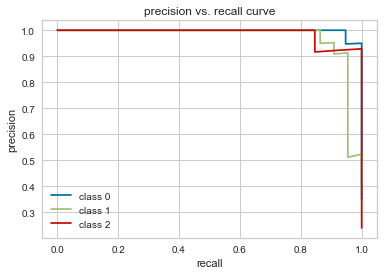

In [16]:
# plot the curves for each class

for i in range(3):
    
    plt.plot(recall_rf[i], precision_rf[i], label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

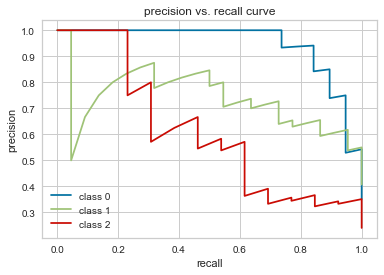

In [17]:
# and now for the logistic regression

precision_lg = dict()
recall_lg = dict()

# for each class
for i in range(3):
    
    # determine precision and recall at various thresholds
    # in a 1 vs all fashion
    precision_lg[i], recall_lg[i], _ = precision_recall_curve(
        y_test[:, i], y_test_logit[:, i])
    
    plt.plot(recall_lg[i], precision_lg[i], label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

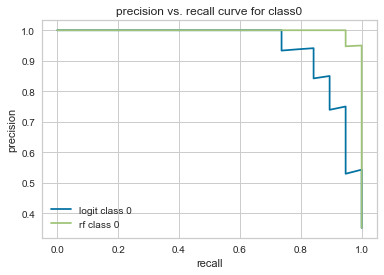

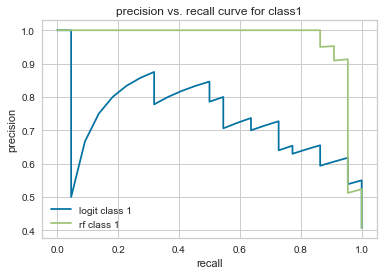

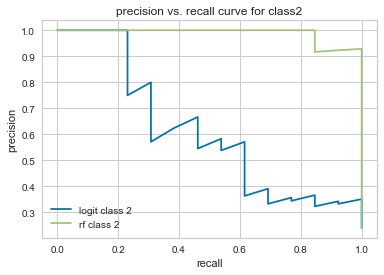

In [18]:
# and now, just because it is a bit difficult to compare
# between models, we plot the PR curves class by class, 
# but the 2 models in the same plot


# for each class
for i in range(3):
       
    plt.plot(recall_lg[i], precision_lg[i], label='logit class {}'.format(i))
    plt.plot(recall_rf[i], precision_rf[i], label='rf class {}'.format(i))
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve for class{}".format(i))
    plt.show()

We see that the Random Forest does a better job for all classes.

### Micro-average with sklearn

In order to do this, we concatenate all the probability vectors 1 after the other, and so we do with the real values.

In [19]:
# probability vectors for all classes in 1-d vector
y_test_rf.ravel()

array([0.65585892, 0.30751478, 0.0366263 , 0.05518233, 0.25215179,
       0.69266589, 0.34795739, 0.5812701 , 0.07077251, 0.63193034,
       0.32889668, 0.03917297, 0.30310868, 0.49998879, 0.19690253,
       0.37648223, 0.53413382, 0.08938395, 0.59288054, 0.31292709,
       0.09419236, 0.05019807, 0.22826575, 0.72153618, 0.18841092,
       0.71865205, 0.09293703, 0.13170475, 0.67533883, 0.19295642,
       0.14215091, 0.29068131, 0.56716779, 0.03969788, 0.32611392,
       0.6341882 , 0.67049232, 0.29443878, 0.03506889, 0.42327198,
       0.50031035, 0.07641767, 0.0591323 , 0.26832053, 0.67254717,
       0.15374694, 0.77041466, 0.07583841, 0.58034038, 0.38076094,
       0.03889868, 0.62403154, 0.34111956, 0.0348489 , 0.1354814 ,
       0.42117747, 0.44334113, 0.65216469, 0.31081584, 0.03701947,
       0.40973074, 0.52592483, 0.06434443, 0.55023138, 0.40190058,
       0.04786804, 0.44236274, 0.45261204, 0.10502522, 0.13095529,
       0.7700388 , 0.09900591, 0.14384689, 0.30677854, 0.54937

In [20]:
# see that the unravelled prediction vector has 3 times the size
# of the origina target

len(y_test), len(y_test_rf.ravel())

(54, 162)

In [21]:
# A "micro-average": quantifying score on all classes jointly

# for random forests
precision_rf["micro"], recall_rf["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_test_rf.ravel(),
)

# for logistic regression
precision_lg["micro"], recall_lg["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_test_logit.ravel(),
)

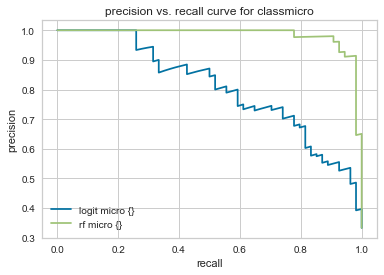

In [22]:
# now we plot them next to each other

i = "micro"

plt.plot(recall_lg[i], precision_lg[i], label='logit micro {}')
plt.plot(recall_rf[i], precision_rf[i], label='rf micro {}')

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve for class{}".format(i))
plt.show()

## Yellowbrick

### Per class with Yellobrick

https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html

**Note:**

In the cells below, we are passing to Yellobrick classes a model that is already fit. When we fit() the Yellobrick class, it will check if the model is fit, in which case it will do nothing.

If we pass a model that is not fit, and a multiclass target, Yellowbrick will wrap the model automatically with a 1 vs Rest classifier. 

Check Yellobrick's documentation for more details.

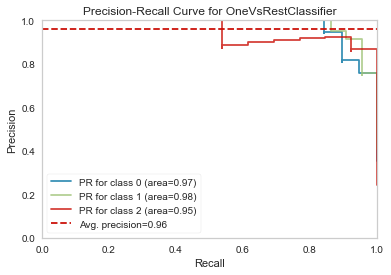

<Axes: title={'center': 'Precision-Recall Curve for OneVsRestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [23]:
visualizer = PrecisionRecallCurve(
    rf, per_class=True, micro=False,
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was depreca

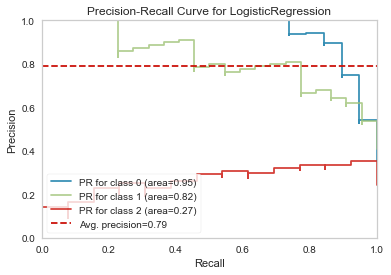

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [24]:
visualizer = PrecisionRecallCurve(
    logit, per_class=True, micro=False,
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

### Micro yellowbrick

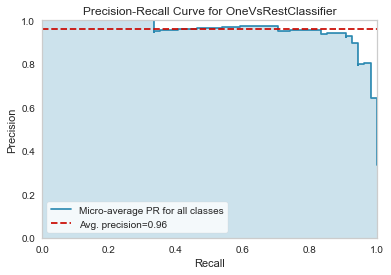

<Axes: title={'center': 'Precision-Recall Curve for OneVsRestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [25]:
visualizer = PrecisionRecallCurve(
    rf, micro=True,
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was depreca

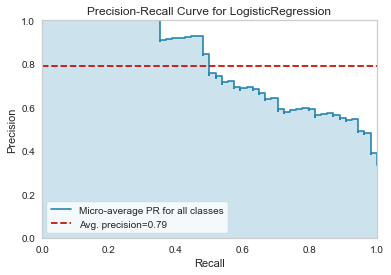

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [26]:
visualizer = PrecisionRecallCurve(
    logit, micro=True,
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

That's all for PR curves